In [1]:
import numpy as np
import pandas as pd
from os import path
from random import choice, shuffle

from ga4stpg.graph import Graph, ReaderORLibrary
from ga4stpg.graph.steiner import (prunning_mst, shortest_path,
                            shortest_path_origin_prim,
                            prunning_kruskal_mst,
                            shortest_path_with_origin)

from ga4stpg.graph.util import (is_steiner_tree, 
                                has_cycle)


In [2]:
from ga4stpg.tree.pxcrossover import PXTree
from ga4stpg.tree.evaluation import EvaluateTreeGraph
from ga4stpg.tree.generate import GenerateBasedPrimRST

In [3]:
# input
input_file = 'steinc5.txt'
folder_datasets = path.join('..', '..', 'ppgi-stpg-gpx', 'datasets', 'ORLibrary')

filename = path.join(folder_datasets, input_file)
print(filename)

assert path.exists(filename)

reader = ReaderORLibrary()

stpg = reader.parser(filename)

..\..\ppgi-stpg-gpx\datasets\ORLibrary\steinc5.txt


In [4]:
crossover = PXTree(stpg)
evaluator = EvaluateTreeGraph(stpg)
generator = GenerateBasedPrimRST(stpg)

In [5]:
%%time

data = list()
print(stpg.nro_nodes)

for _ in range(200):
    
    aa = generator()
    is_aa_st, _ = is_steiner_tree(aa, stpg)
    aa_cost, _ = evaluator(aa)

    
    bb = generator()
    is_bb_st, _ = is_steiner_tree(bb, stpg)
    bb_cost, _ = evaluator(bb)
    
    child = crossover(aa, bb)
    cc_cost, _ = evaluator(child)
    is_cc_st, _ = is_steiner_tree(child, stpg)
    
    data.append([is_aa_st, is_bb_st, is_cc_st, aa_cost, bb_cost, cc_cost])

500
Wall time: 21.7 s


In [6]:
%%time

col = ['is_aa_st', 
    'is_bb_st', 
    'is_cc_st' ,
    'a_cost', 
    'b_cost', 
    'c_cost'
    ]

frame = pd.DataFrame(data, columns=col)

Wall time: 2 ms


In [7]:
frame['less_both'] = (frame['c_cost'] < frame['a_cost']) & (frame['c_cost'] < frame['b_cost'])

In [8]:
frame['less_equal_both'] = (frame['c_cost'] <= frame['a_cost']) & (frame['c_cost'] <= frame['b_cost'])

In [9]:
frame['less_equal_a'] = (frame['c_cost'] <= frame['a_cost'])

In [10]:
frame['less_equal_b'] = (frame['c_cost'] <= frame['b_cost'])

In [11]:
frame.head()

,is_aa_st,is_bb_st,is_cc_st,a_cost,b_cost,c_cost,less_both,less_equal_both,less_equal_a,less_equal_b
0,False,False,False,2748,2765,2744,True,True,True,True
1,False,False,False,2709,2750,2704,True,True,True,True
2,False,False,False,2725,2749,2718,True,True,True,True
3,False,False,False,2742,2755,2731,True,True,True,True
4,False,False,False,2745,2746,2736,True,True,True,True


In [12]:

# all solutions were classified as steiner tree

# np.all(frame['is_aa_st'])
# np.all(frame['is_bb_st'])
# np.all(frame['is_cc_st'])

frame[['is_aa_st',	'is_bb_st',	'is_cc_st']].describe()

,is_aa_st,is_bb_st,is_cc_st
count,200,200,200
unique,1,1,1
top,False,False,False
freq,200,200,200


In [13]:
frame[['a_cost', 'b_cost','c_cost']].max()

a_cost    2827
b_cost    2821
c_cost    2771
dtype: int64

In [14]:
frame[['a_cost', 'b_cost','c_cost']].min()

a_cost    2662
b_cost    2658
c_cost    2652
dtype: int64

In [15]:
frame[['a_cost', 'b_cost','c_cost']].describe()

,a_cost,b_cost,c_cost
count,200.000000,200.000000,200.000000
mean,2739.245000,2742.420000,2716.135000
std,26.087117,27.822907,24.506727
min,2662.000000,2658.000000,2652.000000
25%,2720.750000,2722.750000,2701.000000
50%,2742.000000,2742.500000,2717.000000
75%,2757.000000,2762.000000,2734.000000
max,2827.000000,2821.000000,2771.000000


In [16]:
frame['diff_from_a'] = frame['a_cost'] - frame['c_cost']
frame['diff_from_b'] = frame['b_cost'] - frame['c_cost']

In [17]:
frame[['diff_from_a', 'diff_from_b']].describe()

,diff_from_a,diff_from_b
count,200.000000,200.000000
mean,23.110000,26.285000
std,22.142478,26.148662
min,0.000000,-28.000000
25%,8.000000,6.750000
50%,16.000000,21.000000
75%,29.250000,41.250000
max,141.000000,105.000000


In [18]:
frame[frame['diff_from_b'] < 0][['a_cost','b_cost', 'c_cost']]

,a_cost,b_cost,c_cost
30,2703,2687,2692
48,2761,2735,2746
61,2757,2738,2745
71,2768,2747,2757
92,2725,2718,2724
101,2737,2721,2723
102,2733,2694,2720
118,2750,2711,2731
130,2714,2694,2701
132,2757,2746,2757


In [19]:
frame.query("c_cost < a_cost & c_cost < b_cost").count()

is_aa_st           172
is_bb_st           172
is_cc_st           172
a_cost             172
b_cost             172
c_cost             172
less_both          172
less_equal_both    172
less_equal_a       172
less_equal_b       172
diff_from_a        172
diff_from_b        172
dtype: int64

In [20]:
frame.query("c_cost == a_cost | c_cost == b_cost").count()

is_aa_st           11
is_bb_st           11
is_cc_st           11
a_cost             11
b_cost             11
c_cost             11
less_both          11
less_equal_both    11
less_equal_a       11
less_equal_b       11
diff_from_a        11
diff_from_b        11
dtype: int64

<AxesSubplot:>

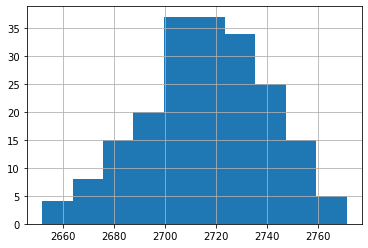

In [21]:
frame['c_cost'].hist()

<AxesSubplot:>

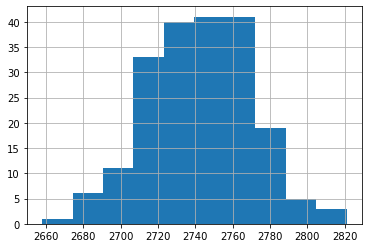

In [22]:
frame['b_cost'].hist()

<AxesSubplot:>

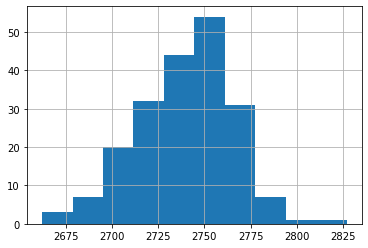

In [23]:
frame['a_cost'].hist()

<AxesSubplot:>

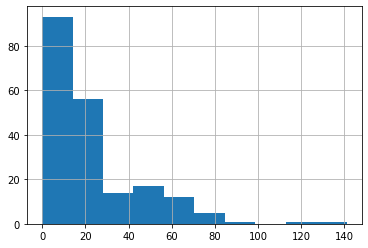

In [24]:
frame['diff_from_a'].hist()

<AxesSubplot:>

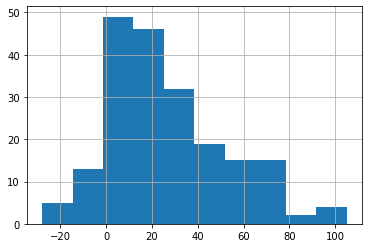

In [25]:
frame['diff_from_b'].hist()